In [1]:
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
path = Path('results/')
path_gen = Path('results/gen/')
path_eff = Path('results/eff/')

In [30]:
from pathlib import Path
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

def load_results(root_path: Path, scalar_names: list, load_from_disk=False):
    # If load_from_disk is True, load the DataFrame from a CSV file in the root path
    if load_from_disk:
        df = pd.read_csv(root_path / 'data.csv')
    else:
        # Create an empty list to store the data
        data = []

        # Loop over all subdirectories of the root path (which should be 'gen' or 'eff')
        for track_path in root_path.iterdir():
            # Check if the subdirectory is a directory
            if track_path.is_dir():
                # Loop over all subdirectories of the track path (which should be algorithm names)
                for method_path in track_path.iterdir():
                    # Check if the subdirectory is a directory
                    if method_path.is_dir():
                        # Print the method name
                        print(method_path.name)
                        # Loop over all subdirectories of the algorithm path (which should be experiment names)
                        for exp_path in method_path.iterdir():
                            # Check if the subdirectory is a directory
                            if exp_path.is_dir():
                                # Initialize the event accumulator and load the event file
                                event_acc = EventAccumulator(str(exp_path))
                                event_acc.Reload()

                                # Initialize an empty DataFrame
                                df = pd.DataFrame()

                                # Loop over the scalar names
                                for scalar_name in scalar_names:
                                    # Check if the scalar exists in the event file
                                    if scalar_name in event_acc.Tags()['scalars']:
                                        # Get the scalar data
                                        scalar_data = event_acc.Scalars(scalar_name)

                                        # Create a DataFrame for the scalar data
                                        scalar_df = pd.DataFrame([(x.step, x.value) for x in scalar_data], columns=['step', scalar_name])

                                        # Merge the scalar DataFrame with the main DataFrame on the 'step' column
                                        if df.empty:
                                            df = scalar_df
                                        else:
                                            df = pd.merge(df, scalar_df, on='step', how='outer')

                                # If the main DataFrame is not empty, add columns for the track, algorithm, and experiment names
                                if not df.empty:
                                    df['track'] = track_path.name
                                    df['method'] = method_path.name
                                    df['experiment'] = exp_path.name

                                    # Add the DataFrame to the list of data
                                    data.append(df)

        # Concatenate all DataFrames into a single DataFrame
        df = pd.concat(data)

        # Save the DataFrame to a CSV file in the root path
        df.to_csv(root_path / 'data.csv', index=False)


    # Further process data

    df['task'] = df['experiment'].apply(lambda x: x.split('_')[0])
    df['seed'] = df['experiment'].apply(lambda x: x.split('seed=')[1].split('_')[0])

    # rename: charts/episodic_return_mean -> train, and charts/episodic_return_mean_eval -> eval
    df = df.rename(columns={'charts/episodic_return_mean': 'train', 'charts/episodic_return_mean_eval': 'eval'})

    # for every track, task and seed, create a smoothed train column - centered rolling mean (window 8)
    df['train_smoothed'] = df.groupby(['track', 'task', 'seed'])['train'].transform(lambda x: x.rolling(8, center=True).mean())

    # create new col which is the difference between the smoothed train and eval
    df['train_eval_ratio'] = df['train_smoothed'] / (df['eval'] + 1e-8)
    
    return df


In [31]:
# GEN PLOTS
load_from_disk = False

scalars = ['charts/episodic_return_mean', 'charts/episodic_return_mean_eval']
df = load_results(path, scalars, load_from_disk=load_from_disk)


impala
mixer-4x4


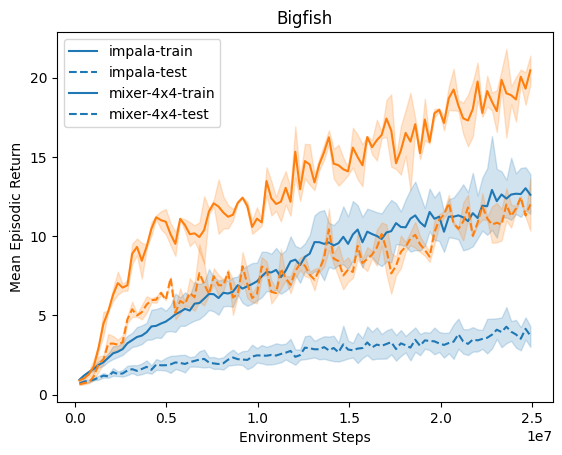

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Filter the data for the 'bigfish' task
filtered_data = df[df['task'] == 'bigfish'].dropna()

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the solid line for the 'train_smooth' data
sns.lineplot(ax=ax, data=filtered_data, x='step', y='train_smoothed', hue='method')

# Plot the dotted line for the 'eval' data
sns.lineplot(ax=ax, data=filtered_data, x='step', y='eval', hue='method', linestyle='--')

# Get the unique methods from the data
methods = filtered_data['method'].unique()

# Create custom legend handles and labels
legend_handles = []
legend_labels = []

for method in methods:
    legend_handles.append(mlines.Line2D([], [], linestyle='-', label=f'{method}-train'))
    legend_handles.append(mlines.Line2D([], [], linestyle='--', label=f'{method}-test'))
    legend_labels.append(f'{method}-train')
    legend_labels.append(f'{method}-test')

# Set the custom legend
ax.legend(handles=legend_handles, labels=legend_labels) # , title='<method>-<train/test>'

# set y label
ax.set_ylabel('Mean Episodic Return')

# set x label
ax.set_xlabel('Environment Steps')

# set title
ax.set_title('Bigfish')

# Show the plot
plt.show()


<AxesSubplot:xlabel='step', ylabel='train_smoothed'>

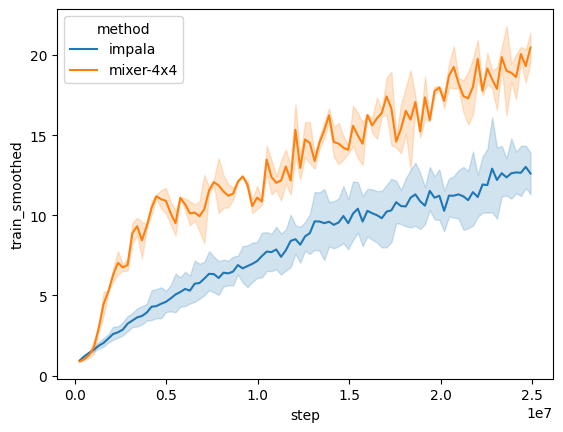

In [29]:
sns.lineplot(data=df[df['task'] == 'bigfish'].dropna(), x='step', y='train_smoothed', hue='method')

<AxesSubplot:xlabel='step', ylabel='eval'>

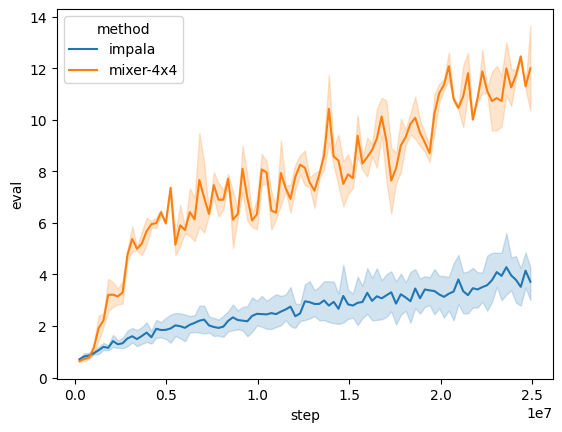

In [28]:
sns.lineplot(data=df[df['task'] == 'bigfish'].dropna(), x='step', y='eval', hue='method')

<AxesSubplot:xlabel='step', ylabel='train_eval_ratio'>

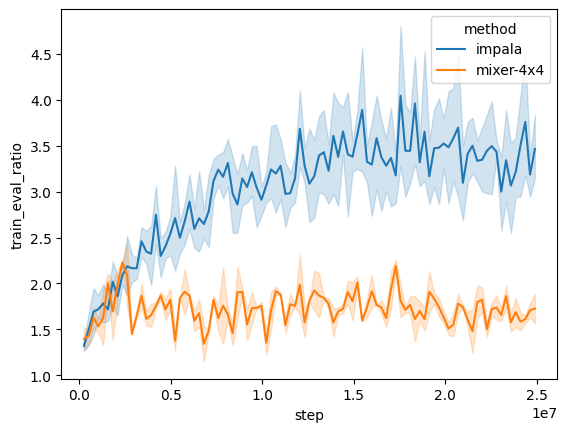

In [27]:
sns.lineplot(data=df[df['task'] == 'bigfish'].dropna(), x='step', y='train_eval_ratio', hue='method')

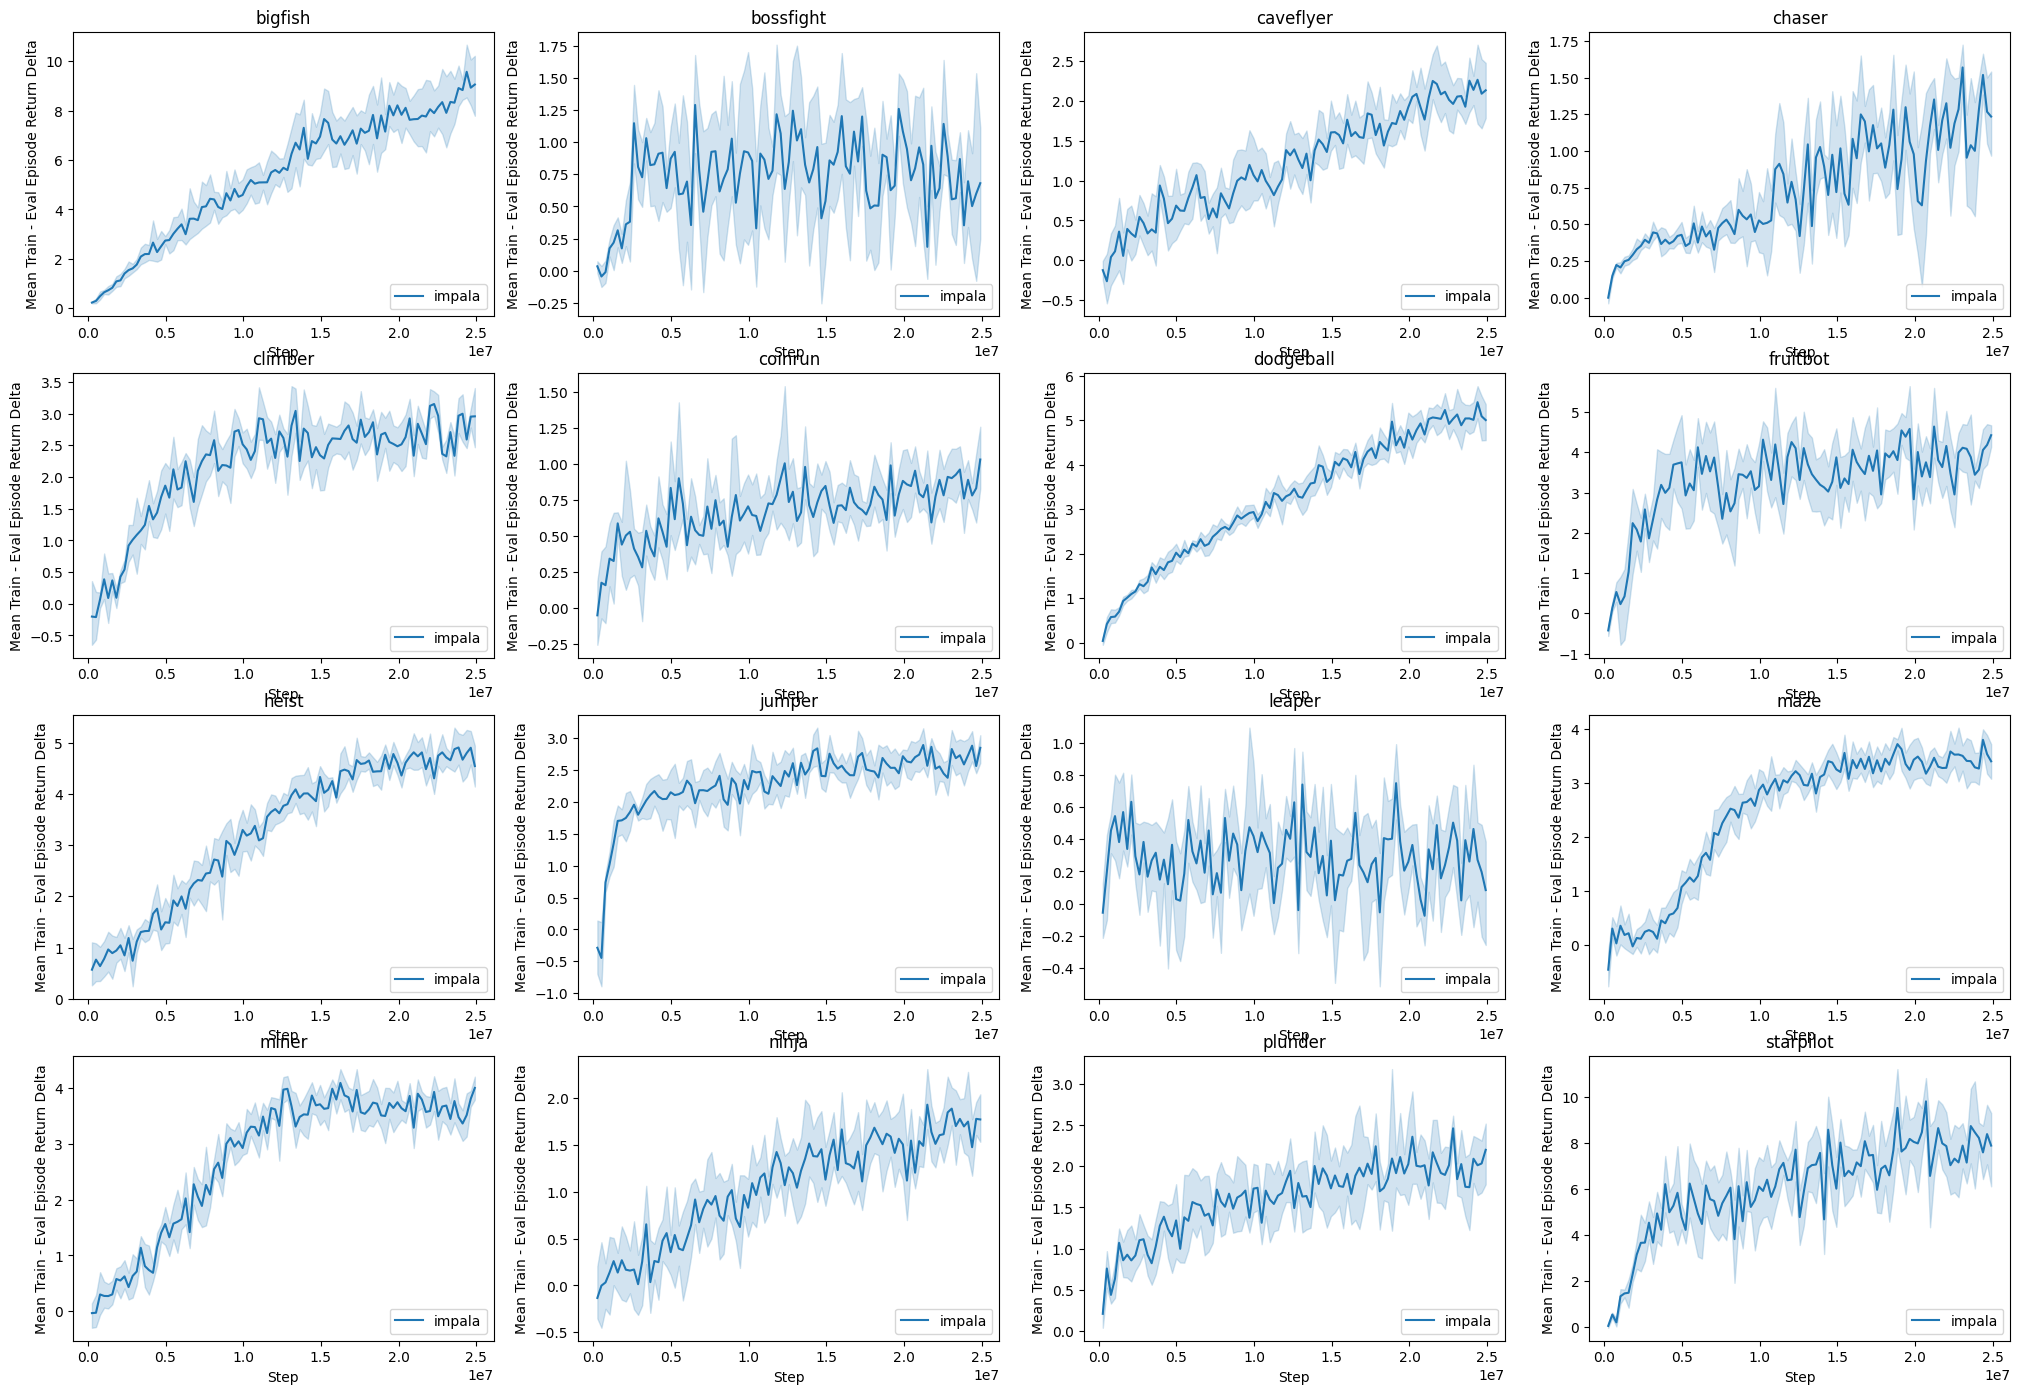

In [64]:
# on a 4x4 grid of axis, plot the mean episodic return for each task, where each algorithm is a different color
fig, axes = plt.subplots(4, 4, figsize=(25, 17))
for i, task in enumerate(sorted(df['task'].unique())):
    ax = axes[i // 4, i % 4]
    sns.lineplot(data=df[df['task'] == task].dropna(), x='step', y='train_eval_delta', hue='method', ax=ax)
    ax.set_title(task)
    ax.set_xlabel('Step')
    ax.set_ylabel('Mean Train - Eval Episode Return Delta')
    ax.legend(loc='lower right')

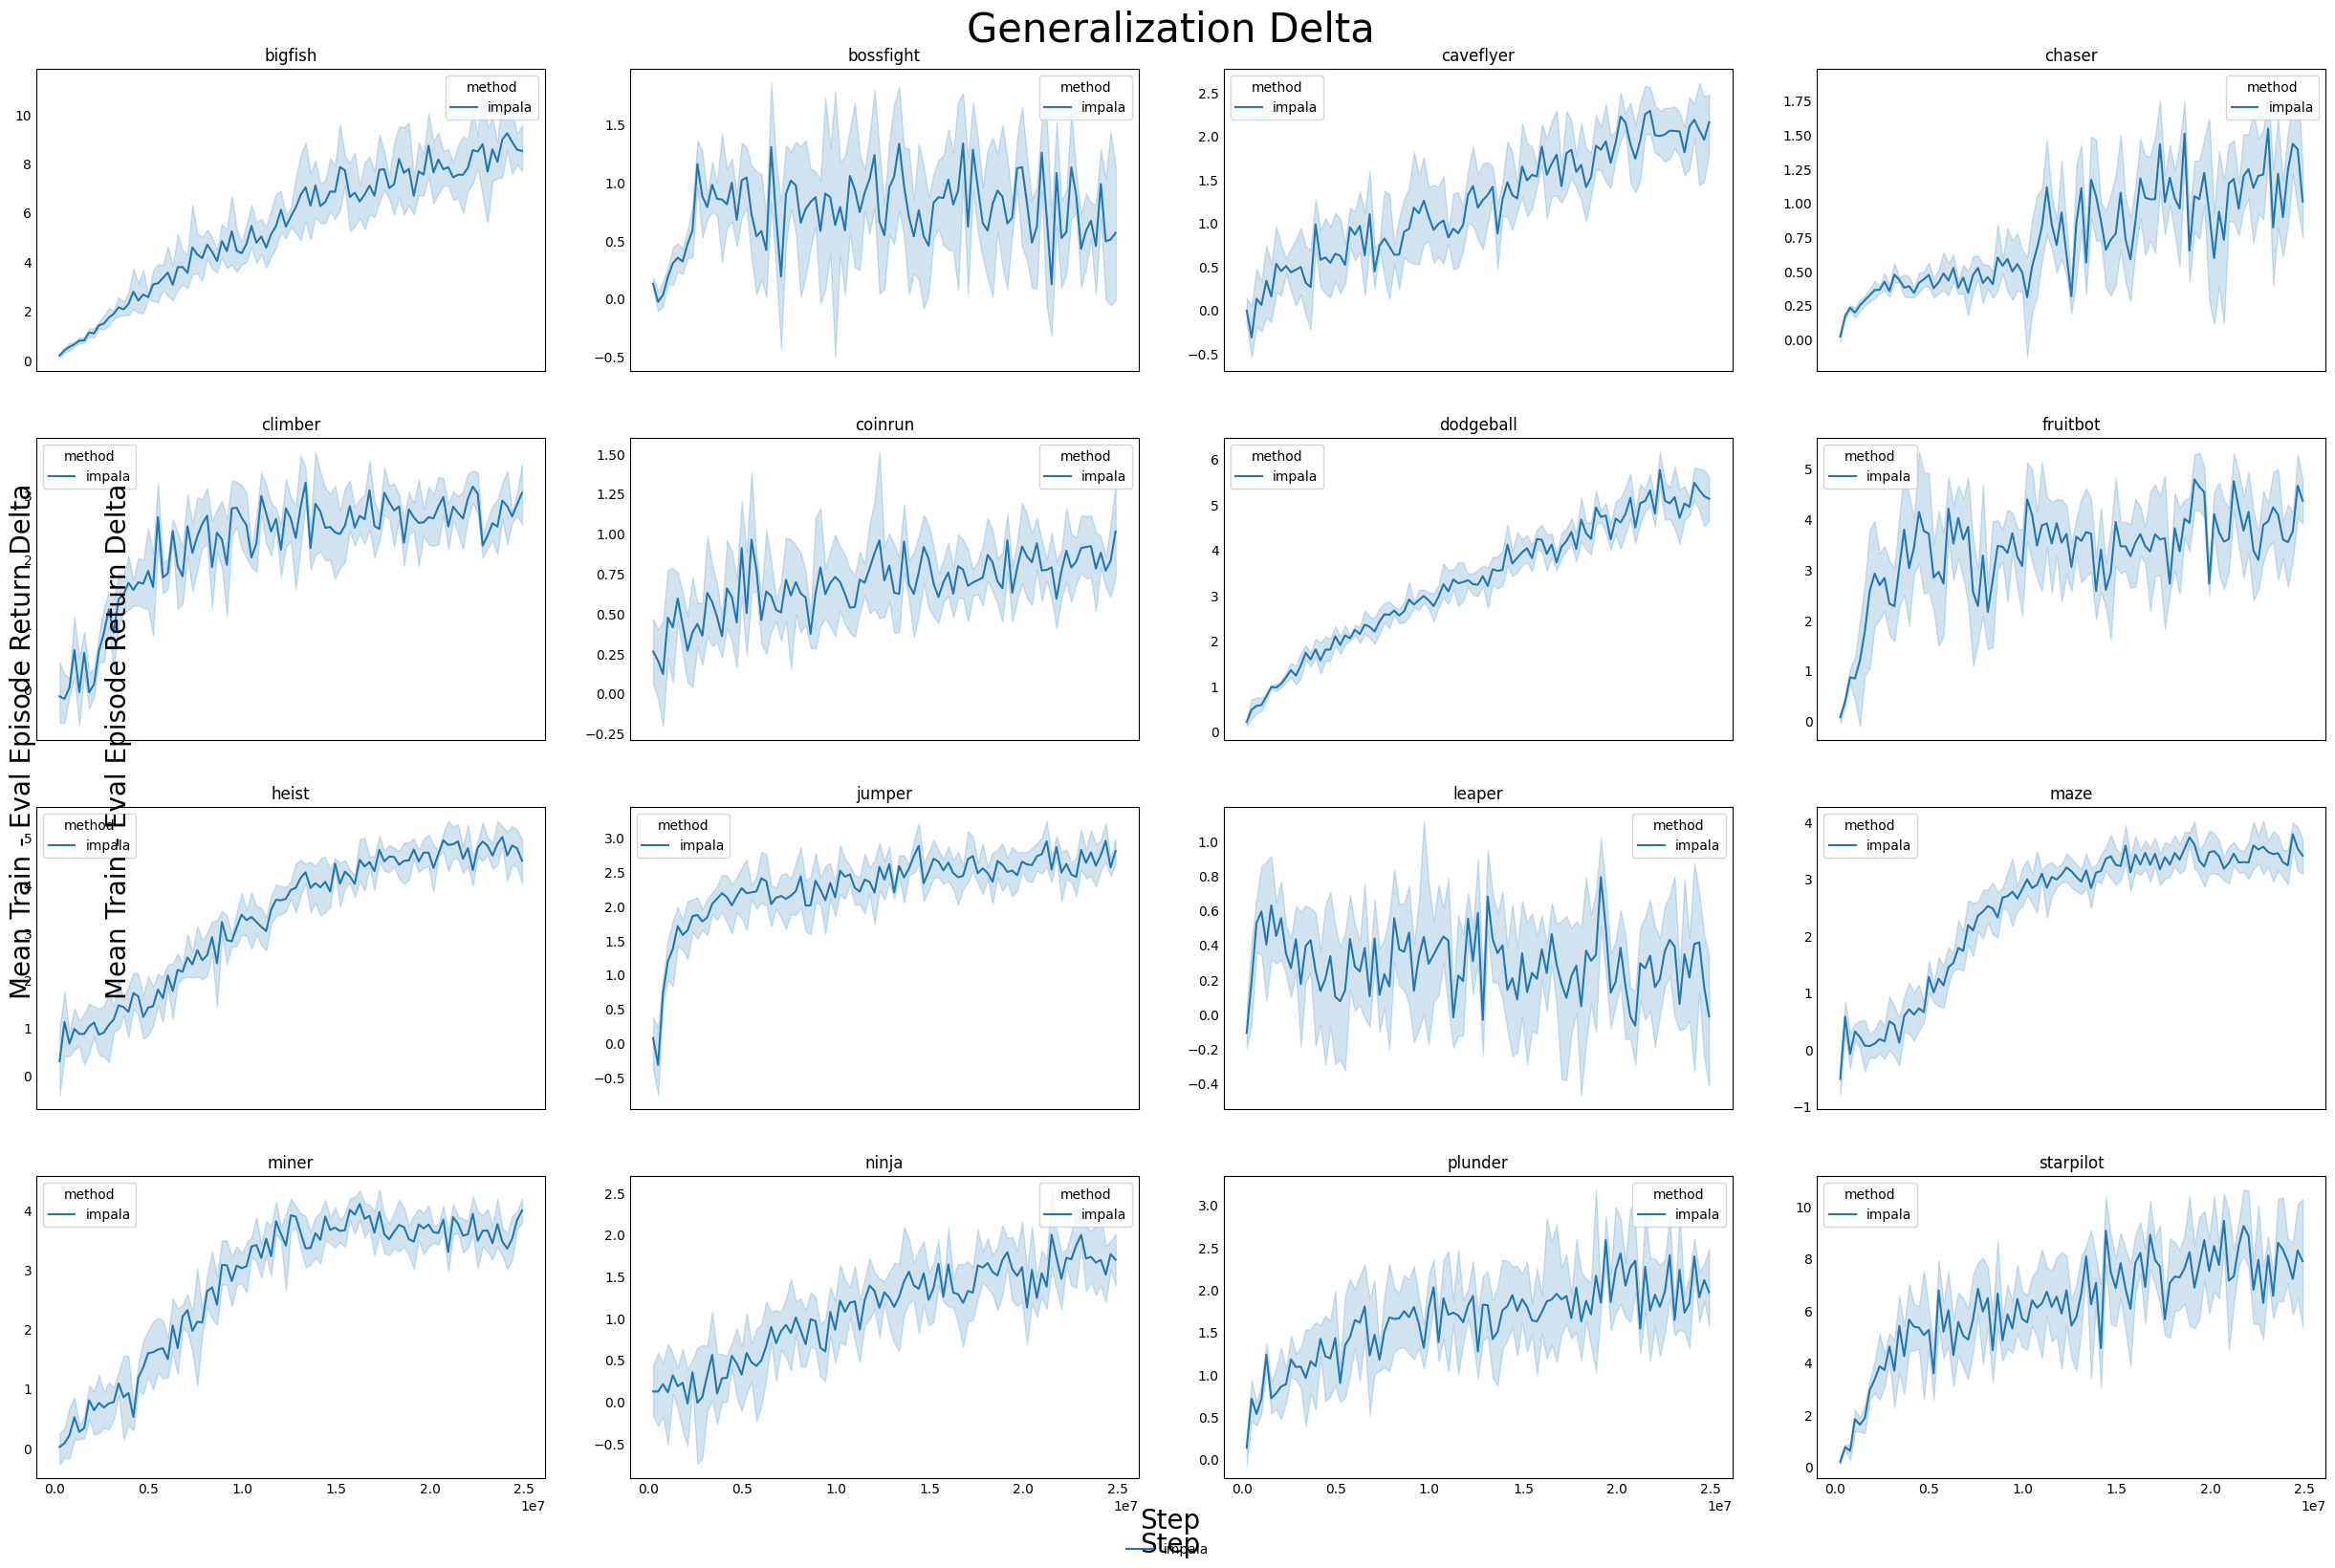

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the figure and axes
fig, axes = plt.subplots(4, 4, figsize=(25, 17), sharex=True)

# Create an empty dictionary to store the legend handles and labels
handles_dict = {}

# Loop over all tasks
for i, task in enumerate(sorted(df['task'].unique())):
    # Get the subplot for the task
    ax = axes[i // 4, i % 4]

    # Plot the data and get the legend handles and labels
    sns.lineplot(data=df[df['task'] == task].dropna(), x='step', y='train_eval_delta', hue='method', ax=ax)
    handles, labels = ax.get_legend_handles_labels()

    # Store the handles and labels in the dictionary
    for handle, label in zip(handles, labels):
        handles_dict[label] = handle

    # Remove the x and y titles on the individual axes
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', length=0)

    # Set the title
    ax.set_title(task)

# Set the legend for the entire figure
fig.legend(handles_dict.values(), handles_dict.keys(), loc='lower center', ncol=len(handles_dict), frameon=False)

# Set the x label for the entire figure
fig.text(0.5, 0.02, 'Step', ha='center', va='center', fontsize=20)

# Set the y label for the entire figure
fig.text(0.06, 0.5, 'Mean Train - Eval Episode Return Delta', ha='center', va='center', rotation='vertical', fontsize=20)

# Add a title for the entire figure
fig.suptitle('Generalization Delta', fontsize=30, x=0.5, y=0.95)

# Move the x and y labels further away from the axes
fig.text(0.5, 0.005, 'Step', ha='center', va='center', fontsize=20)
fig.text(0.02, 0.5, 'Mean Train - Eval Episode Return Delta', ha='center', va='center', rotation='vertical', fontsize=20)

# Add padding between subplots
fig.tight_layout(pad=3.0)
